# Fake News Detection
- Developer Name: Mr. Choong Man Shun
- Student ID: TP051283
- Program Name: Fake News Detection

## Importing Libraries

In [ ]:
import pickle
import re
import string
from collections import Counter

import gensim
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from nltk import PorterStemmer, WordNetLemmatizer, ngrams
from nltk.corpus import stopwords
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tqdm import tqdm
from wordcloud import WordCloud

In [ ]:
nltk.download('omw-1.4')
tqdm.pandas()

## Initial Data Exploration / Exploratory Data Analysis (EDA)

### Reading Datasets
Dataset from [https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

In [2]:
fake_news_df = pd.read_csv("data/fake_news.csv")

In [3]:
true_news_df = pd.read_csv("data/true_news.csv")

### Viewing Data

In [4]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake_news_df.tail()

,title,text,subject,date
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


In [6]:
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
true_news_df.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


### Merging Datasets

In [8]:
fake_news_df["fake"] = 1
true_news_df["fake"] = 0
news_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

In [9]:
news_df.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
news_df.tail()

,title,text,subject,date,fake
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


### Data Dimensions

In [11]:
news_df.shape

(44898, 5)

### Column Names

In [47]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'fake'], dtype='object')

### Metadata

In [12]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


### Descriptive Statistics

In [51]:
stat_df = news_df
stat_df.fake = stat_df.fake.astype(object)
stat_df.describe()

,title,text,subject,date,fake
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",1
freq,14,627,11272,182,23481


### Distribution of Fake and True News

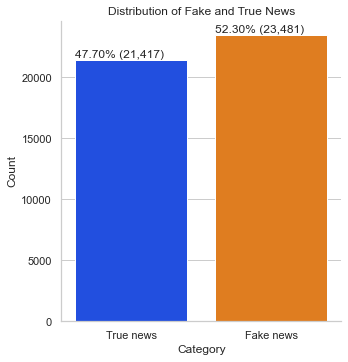

In [88]:
sns.set_theme(style="whitegrid", palette="bright")

catplot = sns.catplot(x="fake", data=news_df, kind="count")
catplot.set(
    xlabel="Category",
    ylabel="Count",
    xticklabels=["True news", "Fake news"],
    title="Distribution of Fake and True News"
)

for patch, category in zip(catplot.ax.patches, [0, 1]):
    height = patch.get_height()
    category_count = sum(news_df.fake == category)
    category_percentage = category_count / len(news_df) * 100
    text = f"{category_percentage:1.2f}% ({category_count:,})"
    catplot.ax.text(patch.get_x(), height + 200, text)

### Distribution across Subjects

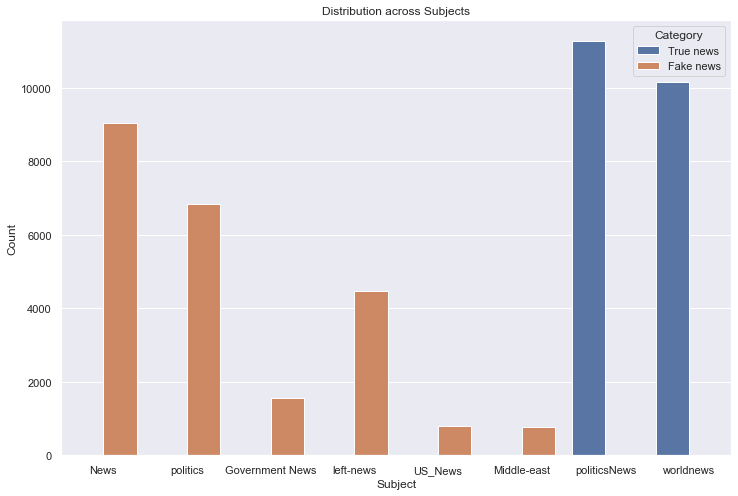

In [70]:
sns.set_theme(style="whitegrid", palette="bright")
sns.set(rc={'figure.figsize': (12, 8)})

countplot = sns.countplot(x="subject", hue="fake", data=news_df)
countplot.set(
    xlabel="Subject", ylabel="Count", title="Distribution across Subjects"
)
countplot.legend(labels=["True news", "Fake news"], title="Category")

### Checking for Missing Values

In [14]:
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

### Checking for Duplicate Values

In [15]:
news_df.duplicated().sum()

209

## Data Cleaning/Pre-processing

### Removing Duplicate Values

In [72]:
unique_news_df = news_df.drop_duplicates()

unique_news_df.duplicated().sum()

0

### Filtering Columns

In [73]:
news_text_df = unique_news_df.loc[:, ["text", "fake"]]
news_text_df.text += " " + unique_news_df.title

news_text_df.head()

,text,fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


### Cleaning Text

In [76]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")

    return soup.get_text()

def remove_url(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_square_bracket(text):
    return re.sub(r"\[.*?]", "", text)

def remove_angle_bracket(text):
    return re.sub(r"<.*?>", "", text)

def remove_newline(text):
    return re.sub(r"\n", "", text)

def remove_punctuation(text):
    return re.sub(fr"[{re.escape(string.punctuation)}]", "", text)

def remove_stopwords(text):
    stopword_set = set(stopwords.words("english"))

    return " ".join(
        word.strip()
        for word in text.split()
        if word.strip().lower() not in stopword_set
    )

def clean_text(text):
    text = remove_html(text)  # strip html tags
    text = remove_url(text)  # remove urls
    text = remove_square_bracket(text)  # remove square brackets
    text = remove_angle_bracket(text)  # remove angle brackets
    text = remove_newline(text)  # remove newlines
    # text = re.sub(r"\w*\d\w*", "", text)  # remove words with digit
    text = remove_punctuation(text)  # remove punctuations
    text = remove_stopwords(text)  # remove stopwords

    return text

news_text_df["clean_text"] = news_text_df.text.progress_apply(clean_text)

news_text_df.clean_text

 25%|██▌       | 11189/44689 [00:17<01:14, 449.32it/s] C:\Users\Choong Man Shun\.virtualenvs\fake-news-detection-cuH1bMUX-py3.9\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 44689/44689 [01:00<00:00, 739.80it/s] 


0        Donald Trump wish Americans Happy New Year lea...
1        House Intelligence Committee Chairman Devin Nu...
2        Friday revealed former Milwaukee Sheriff David...
3        Christmas day Donald Trump announced would bac...
4        Pope Francis used annual Christmas Day message...
                               ...                        
44893    BRUSSELS Reuters NATO allies Tuesday welcomed ...
44894    LONDON Reuters LexisNexis provider legal regul...
44895    MINSK Reuters shadow disused Sovietera factori...
44896    MOSCOW Reuters Vatican Secretary State Cardina...
44897    JAKARTA Reuters Indonesia buy 11 Sukhoi fighte...
Name: clean_text, Length: 44689, dtype: object

### Stemming

In [78]:
stemmer = PorterStemmer()

def stemming(text):
    return " ".join(
        stemmer.stem(word.lower()) for word in text.split()
    )

news_text_df["stemmed_text"] = news_text_df.clean_text.progress_apply(stemming)

news_text_df.stemmed_text

100%|██████████| 44689/44689 [07:28<00:00, 99.74it/s] 


0        donald trump wish american happi new year leav...
1        hous intellig committe chairman devin nune go ...
2        friday reveal former milwauke sheriff david cl...
3        christma day donald trump announc would back w...
4        pope franci use annual christma day messag reb...
                               ...                        
44893    brussel reuter nato alli tuesday welcom presid...
44894    london reuter lexisnexi provid legal regulator...
44895    minsk reuter shadow disus sovietera factori mi...
44896    moscow reuter vatican secretari state cardin p...
44897    jakarta reuter indonesia buy 11 sukhoi fighter...
Name: stemmed_text, Length: 44689, dtype: object

### Lemmatisation

In [81]:
lemmatiser = WordNetLemmatizer()

def lemmatisation(text):
    return " ".join(
        lemmatiser.lemmatize(word.lower()) for word in text.split()
    )

news_text_df["lemmatised_text"] = news_text_df.clean_text.progress_apply(lemmatisation)

news_text_df.lemmatised_text

100%|██████████| 44689/44689 [01:39<00:00, 448.00it/s] 


0        donald trump wish american happy new year leav...
1        house intelligence committee chairman devin nu...
2        friday revealed former milwaukee sheriff david...
3        christmas day donald trump announced would bac...
4        pope francis used annual christmas day message...
                               ...                        
44893    brussels reuters nato ally tuesday welcomed pr...
44894    london reuters lexisnexis provider legal regul...
44895    minsk reuters shadow disused sovietera factory...
44896    moscow reuters vatican secretary state cardina...
44897    jakarta reuters indonesia buy 11 sukhoi fighte...
Name: lemmatised_text, Length: 44689, dtype: object

### Assigning Independent and Dependent Variables

In [21]:
x = news_text_df.lemmatised_text

x

0        donald trump wish american happy new year leav...
1        house intelligence committee chairman devin nu...
2        friday revealed former milwaukee sheriff david...
3        christmas day donald trump announced would bac...
4        pope francis used annual christmas day message...
                               ...                        
44893    brussels reuters nato ally tuesday welcomed pr...
44894    london reuters lexisnexis provider legal regul...
44895    minsk reuters shadow disused sovietera factory...
44896    moscow reuters vatican secretary state cardina...
44897    jakarta reuters indonesia buy 11 sukhoi fighte...
Name: lemmatised_text, Length: 44689, dtype: object

In [22]:
y = news_text_df.fake

y

0        1
1        1
2        1
3        1
4        1
        ..
44893    0
44894    0
44895    0
44896    0
44897    0
Name: fake, Length: 44689, dtype: int64

### Splitting Data into Training and Test Sets

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Training set size: 35751
Test set size: 8938


### Vectorising Text

In [24]:
vectorisation = TfidfVectorizer()
vectorised_x_train = vectorisation.fit_transform(x_train)
vectorised_x_test = vectorisation.transform(x_test)

### Transforming Text to Sequences

In [161]:
max_features = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [169]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_len)

x_train_seq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [168]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_len)

x_test_seq[0]

array([ 178,  199,  268,  185,  256,   33,  261,  196, 3688,  415, 1513,
       9432, 4034, 1819,    2, 6804,  377, 1355, 1633, 2880,  515,  199,
       5285, 3894,   10,   53,  501,  777,   46,  515,  419,  392,  229,
       3092, 2251, 2827,  199,  241,  404, 1762, 2841, 4088,  259,  739,
         61,  162,  108,  570, 1114, 6247, 1698, 3695, 1667, 1771, 1074,
       1586, 1697,  782, 1715,   93,   22,   14,  682, 5105,    9,  199,
       1189,    4,  285,  101,  882, 2433,  199,  161, 4493,  369, 1037,
       2827,    4,   53, 2174, 2130, 2174, 4125, 6260,  199,  607, 1355,
        777,  297,  286, 7726,   43, 8261, 3030,  501, 1327, 1138,    9,
       4982,   35, 4982, 1157, 4982, 2130, 4982, 1998,  777,  132,  894,
       6118, 1802,  198,   92,  259, 2498, 2252,  415, 7012, 2841,  334,
         22,   14, 3007,  251, 1601, 2880, 3268,   28,  864, 3272,  199,
       5285, 2057,  111,  532, 4081, 1413, 1158, 9842, 2694, 2451,  109,
       6015,  240, 9094, 8303,  109,   16,  291, 97

### Vocabulary Size

In [167]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

vocab_size

214634

### Converting Text Column to Lists of Words

In [166]:
sentences = [row.split() for row in x_train]

sentences[0]

['least',
 'two',
 'vote',
 'donald',
 'trump',
 'count',
 'new',
 'york',
 'primary',
 'daughter',
 'badly',
 'want',
 'fck',
 'son',
 'eric',
 'might',
 'seem',
 'crazy',
 'first',
 'ivanka',
 'campaigning',
 'hard',
 'daddy',
 'eric',
 'trump',
 'appeared',
 'alongside',
 'brother',
 'latter',
 'offered',
 'ship',
 'father',
 'black',
 'critic',
 'country',
 'crazy',
 'seems',
 'truethe',
 'state',
 'new',
 'york',
 'incredibly',
 'strict',
 'voter',
 'registration',
 'law',
 'one',
 'promise',
 'create',
 'issue',
 'people',
 'party',
 'many',
 'state',
 'new',
 'york',
 'operates',
 'closed',
 'primary',
 'system',
 'simply',
 'put',
 'cannot',
 'vote',
 'party',
 'primary',
 'unless',
 'registered',
 'party',
 'normally',
 'simply',
 'switching',
 'party',
 'would',
 'solve',
 'issue',
 'nicely',
 'empire',
 'state',
 'earliest',
 'changeofparty',
 'deadline',
 'country',
 'october',
 '9',
 'last',
 'year',
 'six',
 'month',
 'primary',
 'electionyahoo',
 'news',
 'report',
 'eri

## Data Visualisation

### Proportion of Fake and True News

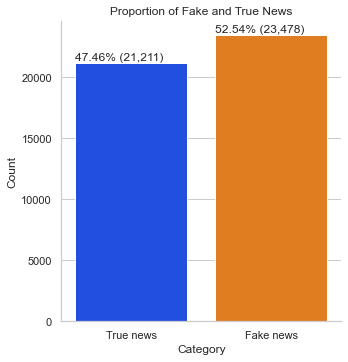

In [87]:
sns.set_theme(style="whitegrid", palette="bright")

catplot = sns.catplot(x="fake", data=news_text_df, kind="count")
catplot.set(
    xlabel="Category",
    ylabel="Count",
    xticklabels=["True news", "Fake news"],
    title="Proportion of Fake and True News"
)

for patch, category in zip(catplot.ax.patches, [0, 1]):
    height = patch.get_height()
    category_count = sum(news_text_df.fake == category)
    category_percentage = category_count / len(news_text_df) * 100
    text = f"{category_percentage:1.2f}% ({category_count:,})"
    catplot.ax.text(patch.get_x(), height + 200, text)

### Word Cloud

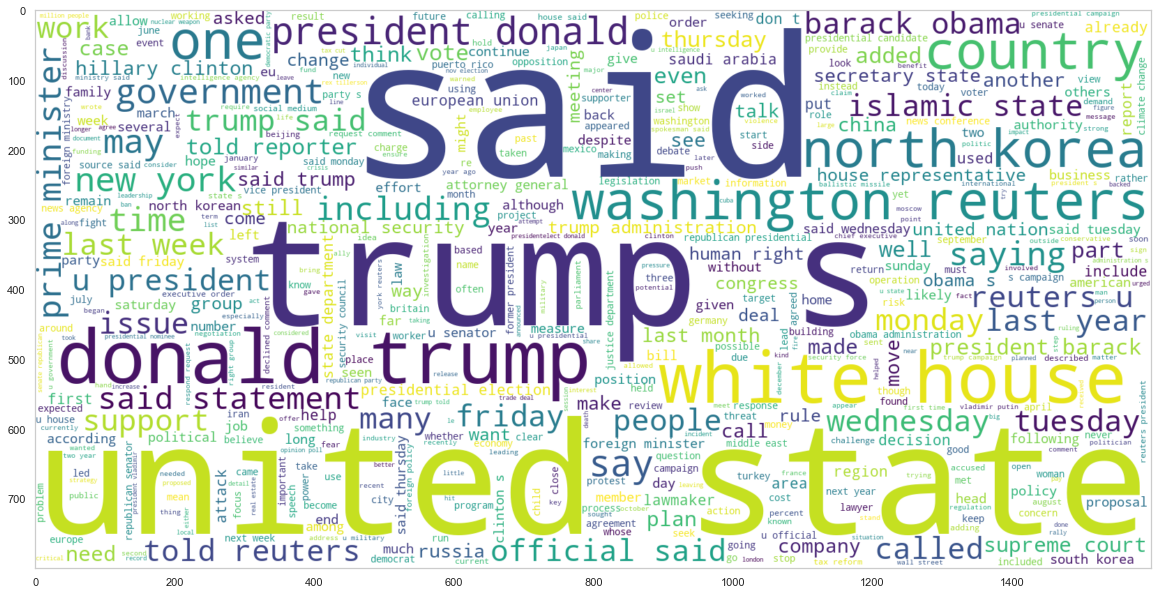

In [28]:
wordcloud = WordCloud(
    background_color="white", max_words=500, width=1600, height=800
)
wordcloud = wordcloud.generate(
    " ".join(news_text_df[news_text_df.fake == 0].lemmatised_text)
)
plt.figure(figsize=(20, 20))
plt.grid(None)
plt.imshow(wordcloud, interpolation="bilinear")

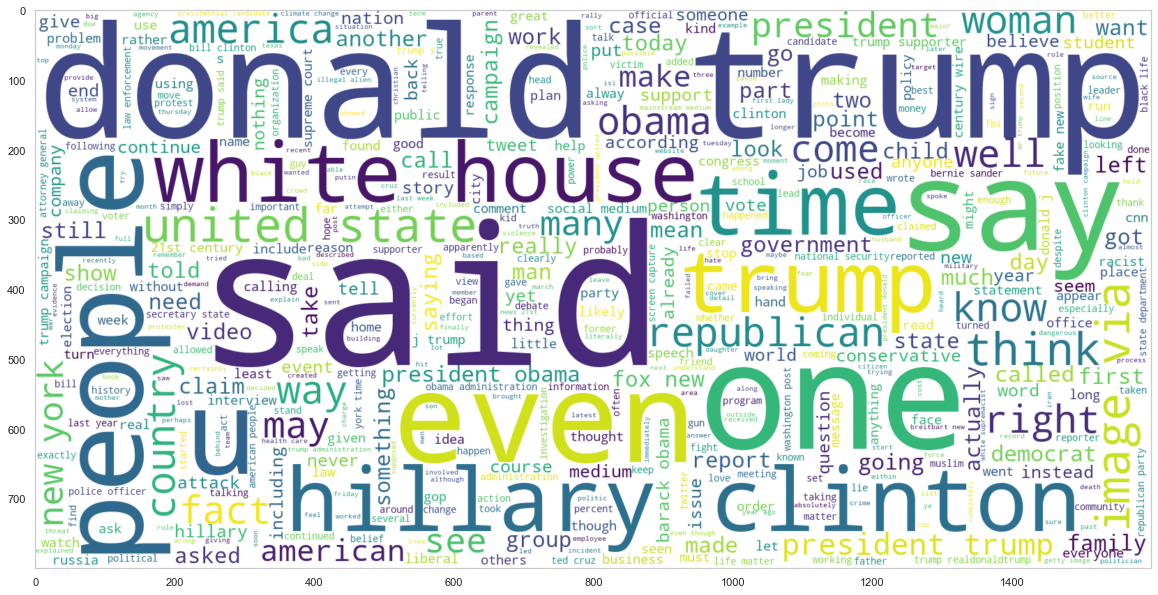

In [29]:
wordcloud = WordCloud(
    background_color="white", max_words=500, width=1600, height=800
)
wordcloud = wordcloud.generate(
    " ".join(news_text_df[news_text_df.fake == 1].lemmatised_text)
)
plt.figure(figsize=(20, 20))
plt.grid(None)
plt.imshow(wordcloud, interpolation="bilinear")

### Average Character Count

In [ ]:
char_count_df = pd.DataFrame()
char_count_df["char_count"] = (
    news_text_df[news_text_df.fake == 0].lemmatised_text.str.len()
)

sns.set_theme(style="whitegrid", palette="bright")

histplot = sns.histplot(
    data=char_count_df, x="char_count", bins=20, kde=True
)
histplot.set(
    xlabel="Average Character Count",
    ylabel="Count",
    title="Histogram of Average Character Count in True News"
)

In [ ]:
char_count_df = pd.DataFrame()
char_count_df["char_count"] = (
    news_text_df[news_text_df.fake == 1].lemmatised_text.str.len()
)

sns.set_theme(style="whitegrid", palette="bright")

histplot = sns.histplot(
    data=char_count_df, x="char_count", bins=20, kde=True, color="darkorange"
)
histplot.set(
    xlabel="Average Character Count",
    ylabel="Count",
    title="Histogram of Average Character Count in Fake News"
)

### Average Word Count

In [ ]:
word_count_df = pd.DataFrame()
word_count_df["word_count"] = (
    news_text_df[news_text_df.fake == 0].lemmatised_text.str.split().map(len)
)

sns.set_theme(style="whitegrid", palette="bright")
histplot = sns.histplot(data=word_count_df, x="word_count", bins=30, kde=True)
histplot.set(
    xlabel="Average Word Count",
    ylabel="Count",
    title="Histogram of Average Word Count in True News"
)

In [ ]:
word_count_df = pd.DataFrame()
word_count_df["word_count"] = (
    news_text_df[news_text_df.fake == 1].lemmatised_text.str.split().map(len)
)

sns.set_theme(style="whitegrid", palette="bright")
histplot = sns.histplot(
    data=word_count_df, x="word_count", bins=30, kde=True, color="darkorange"
)
histplot.set(
    xlabel="Average Word Count",
    ylabel="Count",
    title="Histogram of Average Word Count in Fake News"
)

### Average Word Length

In [ ]:
word_len_df = pd.DataFrame()
word_len_df["word_len"] = news_text_df[news_text_df.fake == 0].lemmatised_text.apply(
    lambda text: np.mean([len(word) for word in text.split()])
)

sns.set_theme(style="whitegrid", palette="bright")

histplot = sns.histplot(data=word_len_df, x="word_len", bins=35, kde=True)
histplot.set(
    xlabel="Average Word Length",
    ylabel="Count",
    title="Histogram of Average Word Length in True News"
)

In [ ]:
word_len_df = pd.DataFrame()
word_len_df["word_len"] = news_text_df[news_text_df.fake == 1].lemmatised_text.apply(
    lambda text: np.mean([len(word) for word in text.split()])
)

sns.set_theme(style="whitegrid", palette="bright")

histplot = sns.histplot(
    data=word_len_df, x="word_len", bins=35, kde=True, color="darkorange"
)
histplot.set(
    xlabel="Average Word Length",
    ylabel="Count",
    title="Histogram of Average Word Length in Fake News"
)

### Most Common Unigram Words

In [ ]:
words = " ".join(news_text_df.lemmatised_text).split()

In [ ]:
unigram = ngrams(words, 1)
unigram_counter = Counter(unigram)
most_common_unigrams = unigram_counter.most_common(10)

unigram_words = [" ".join(words) for words, count in most_common_unigrams]
unigram_counts = [count for words, count in most_common_unigrams]

sns.set_theme(style="whitegrid", palette="bright")

barplot = sns.barplot(x=unigram_words, y=unigram_counts)
barplot.bar_label(barplot.containers[0])
barplot.set(
    xlabel="Unigram Word", ylabel="Count", title="Most Common Unigram Words"
)

### Most Common Bigram Words

In [ ]:
bigram = ngrams(words, 2)
bigram_counter = Counter(bigram)
most_common_bigrams = bigram_counter.most_common(10)

bigram_words = [" ".join(words) for words, count in most_common_bigrams]
bigram_counts = [count for words, count in most_common_bigrams]

sns.set_theme(style="whitegrid", palette="bright")

barplot = sns.barplot(x=bigram_words, y=bigram_counts)
barplot.bar_label(barplot.containers[0])
barplot.set(
    xlabel="Bigram Word", ylabel="Count", title="Most Common Bigram Words"
)

plt.xticks(rotation=-30)

### Most Common Trigram Words

In [ ]:
trigram = ngrams(words, 3)
trigram_counter = Counter(trigram)
most_common_trigrams = trigram_counter.most_common(10)

trigram_words = [" ".join(words) for words, count in most_common_trigrams]
trigram_counts = [count for words, count in most_common_trigrams]

sns.set_theme(style="whitegrid", palette="bright")

barplot = sns.barplot(x=trigram_words, y=trigram_counts)
barplot.bar_label(barplot.containers[0])
barplot.set(
    xlabel="Trigram Word", ylabel="Count", title="Most Common Trigram Words"
)

plt.xticks(rotation=-30)

## Model Construction

### Logistic Regression

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(vectorised_x_train, y_train)

# 0.9879732739420936 (stem)
# 0.9900425151040502 (lemma)

In [280]:
# filename = 'model/lr_model.sav'
# pickle.dump(lr_model, open(filename, 'wb'))

In [115]:
lr_acc = lr_model.score(vectorised_x_test, y_test)

f"Logistic Regression Accuracy: {lr_acc:.2%}"

('Logistic Regression Accuracy: ', '99.00%')

In [114]:
predicted_y_test = lr_model.predict(vectorised_x_test)

print(classification_report(y_test, predicted_y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4200
           1       0.99      0.99      0.99      4738

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



### Decision Tree Classifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(vectorised_x_train, y_train)

# 0.9978841870824053 (stem)
# 0.9960841351532781 (lemma)

In [279]:
# filename = 'model/dt_model.sav'
# pickle.dump(dt_model, open(filename, 'wb'))

In [139]:
dt_acc = dt_model.score(vectorised_x_test, y_test)

f"Decision Tree Classifier Accuracy: {dt_acc:.2%}"

'Decision Tree Classifier Accuracy: 99.61%'

In [140]:
predicted_y_test = dt_model.predict(vectorised_x_test)

print(classification_report(y_test, predicted_y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4200
           1       1.00      1.00      1.00      4738

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



### Gradient Boosting Classifier

In [ ]:
gbc_model = GradientBoostingClassifier(random_state=1)
gbc_model.fit(vectorised_x_train, y_train)

# 0.994988864142539 (stem)
# 0.9953009621839337 (lemma)

In [278]:
# filename = 'model/gbc_model.sav'
# pickle.dump(gbc_model, open(filename, 'wb'))

In [145]:
gbc_acc = gbc_model.score(vectorised_x_test, y_test)

f"Gradient Boosting Classifier Accuracy: {gbc_acc:.2%}"

'Gradient Boosting Classifier Accuracy: 99.53%'

In [147]:
predicted_y_test = gbc_model.predict(vectorised_x_test)

print(classification_report(y_test, predicted_y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4200
           1       1.00      0.99      1.00      4738

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



### Random Forest Classifier

In [ ]:
rfc_model = RandomForestClassifier(random_state=0)
rfc_model.fit(vectorised_x_train, y_train)

# 0.989532293986637 (stem)
# 0.994182143656299 (lemma)

In [277]:
# filename = 'model/rfc_model.sav'
# pickle.dump(rfc_model, open(filename, 'wb'))

In [153]:
rfc_acc = rfc_model.score(vectorised_x_test, y_test)

f"Random Forest Classifier Accuracy: {rfc_acc:.2%}"

'Random Forest Classifier Accuracy: 99.42%'

In [154]:
predicted_y_test = rfc_model.predict(vectorised_x_test)

print(classification_report(y_test, predicted_y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4200
           1       1.00      0.99      0.99      4738

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



### Recurrent Neural Network (RNN)

Word2Vec Model

In [30]:
dim_size = 100
w2v_model = gensim.models.Word2Vec(
    sentences, vector_size=dim_size, window=10, min_count=1
)

Most Similar Words

[Text(0.5, 0, 'Word'),
 Text(0, 0.5, 'Similarity'),
 Text(0.5, 1.0, "Most Similar Words to 'malaysia'")]

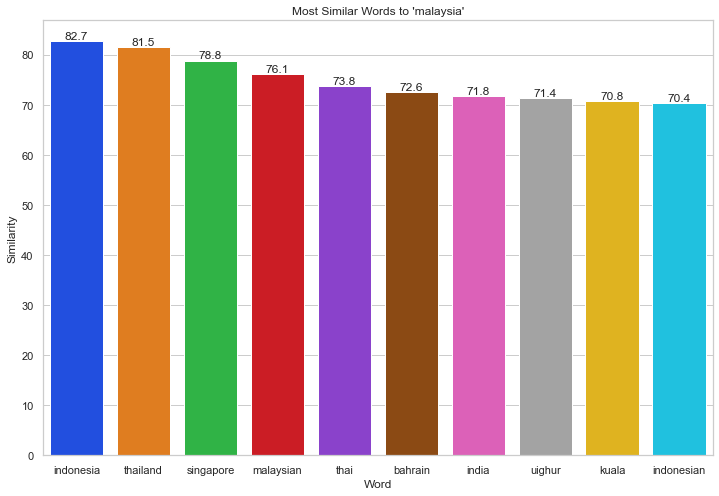

In [184]:
word = "malaysia"
most_similar_words = w2v_model.wv.most_similar(word)

sns.set_theme(style="whitegrid", palette="bright")

barplot = sns.barplot(
    x=[word for word, _ in most_similar_words],
    y=[round(count * 100, 1) for _, count in most_similar_words]
)
barplot.bar_label(barplot.containers[0])
barplot.set(
    xlabel="Word",
    ylabel="Similarity",
    title=f"Most Similar Words to '{word}'"
)

Least Similar Words

[Text(0.5, 0, 'Word'),
 Text(0, 0.5, 'Similarity'),
 Text(0.5, 1.0, "Least Similar Words to 'malaysia'")]

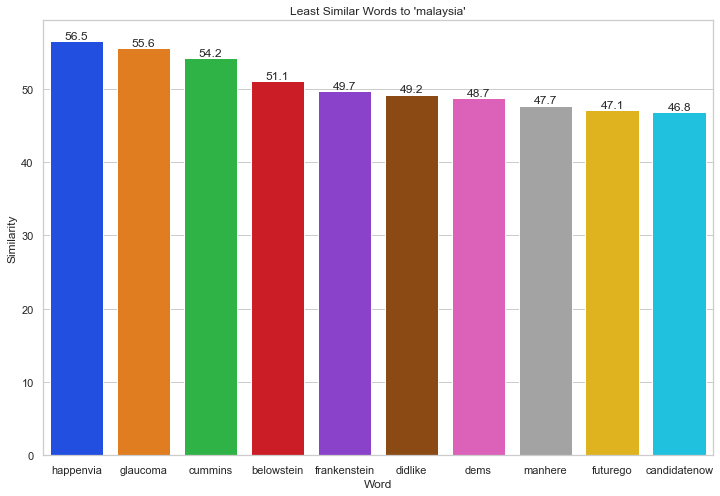

In [185]:
word = "malaysia"
least_similar_words = w2v_model.wv.most_similar(negative=word)

sns.set_theme(style="whitegrid", palette="bright")

barplot = sns.barplot(
    x=[word for word, _ in least_similar_words],
    y=[round(count * 100, 1) for _, count in least_similar_words]
)
barplot.bar_label(barplot.containers[0])
barplot.set(
    xlabel="Word",
    ylabel="Similarity",
    title=f"Least Similar Words to '{word}'"
)

3-layered RNN

In [32]:
embedding_matrix = np.zeros((vocab_size, dim_size))

for word, index in word_index.items():
    embedding_vector = w2v_model.wv[word]
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(214634, 100)

In [44]:
rnn_model = keras.Sequential()
rnn_model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=dim_size,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
)
rnn_model.add(LSTM(units=128))
rnn_model.add(Dense(1, activation="sigmoid"))
rnn_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [45]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          21463400  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,580,777
Trainable params: 117,377
Non-trainable params: 21,463,400
_________________________________________________________________


In [46]:
rnn_model_history = rnn_model.fit(x_train_seq, y_train, epochs=10, validation_data=(x_test_seq, y_test))

Epoch 1/10
1118/1118 [==============================] - 2621s 2s/step - loss: 0.0670 - accuracy: 0.9770 - val_loss: 0.0269 - val_accuracy: 0.9914
Epoch 2/10
1118/1118 [==============================] - 2569s 2s/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0094 - val_accuracy: 0.9979
Epoch 3/10
1118/1118 [==============================] - 2536s 2s/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 4/10
1118/1118 [==============================] - 1866s 2s/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0073 - val_accuracy: 0.9975
Epoch 5/10
1118/1118 [==============================] - 960s 859ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.0057 - val_accuracy: 0.9984
Epoch 6/10
1118/1118 [==============================] - 1023s 915ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0083 - val_accuracy: 0.9975
Epoch 7/10
1118/1118 [==============================] - 882s 789ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0

In [290]:
# filename = 'model/rnn_model.sav'
# pickle.dump(rnn_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://007a73e8-30a9-4134-abdf-c19fa8b4088f/assets


INFO:tensorflow:Assets written to: ram://007a73e8-30a9-4134-abdf-c19fa8b4088f/assets


In [77]:
# with open('model/rnn_model_history', 'wb') as file_pi:
#     pickle.dump(rnn_model_history.history, file_pi)

In [186]:
predicted_y_test = (rnn_model.predict(x_test_seq) >= 0.5).astype(int)
rnn_acc = accuracy_score(y_test, predicted_y_test)

f"RNN Accuracy: {rnn_acc:.2%}"

280/280 [==============================] - 94s 324ms/step


'RNN Accuracy: 99.91%'

In [ ]:
key_mapping = {
    "accuracy": "Accuracy",
    "loss": "Loss",
    "val_accuracy": "Validation Accuracy",
    "val_loss": "Validation Loss"
}
acc_df = pd.DataFrame(
    [
        [index + 1, key_mapping[key], round(value * 100, 2)]
        for key in ["accuracy", "val_accuracy"]
        for index, value in enumerate(rnn_model_history.history[key])
    ],
    columns=["Epoch", "Metric", "Value"]
)

sns.set_theme(style="whitegrid", palette="bright")

lineplot = sns.lineplot(
    x="Epoch", y="Value", hue="Metric", data=acc_df, marker="o"
)
lineplot.set(title="Model Accuracy")

for index, row in acc_df.iterrows():
    lineplot.text(row["Epoch"], row["Value"], row["Value"])

In [ ]:
loss_df = pd.DataFrame(
    [
        [index + 1, key_mapping[key], round(value * 100, 2)]
        for key in ["loss", "val_loss"]
        for index, value in enumerate(rnn_model_history.history[key])
    ],
    columns=["Epoch", "Metric", "Value"]
)

sns.set_theme(style="whitegrid", palette="bright")

lineplot = sns.lineplot(
    x="Epoch", y="Value", hue="Metric", data=loss_df, marker="o"
)
lineplot.set(title="Model Loss")

for index, row in loss_df.iterrows():
    lineplot.text(row["Epoch"], row["Value"], row["Value"])

In [247]:
print(
    classification_report(
        y_test,
        predicted_y_test,
        target_names=["0 (True news)", "1 (Fake news)"]
    )
)

               precision    recall  f1-score   support

0 (True news)       1.00      1.00      1.00      4200
1 (Fake news)       1.00      1.00      1.00      4738

     accuracy                           1.00      8938
    macro avg       1.00      1.00      1.00      8938
 weighted avg       1.00      1.00      1.00      8938



[Text(0.5, 21.5, 'Predicted'),
 Text(48.5, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix')]

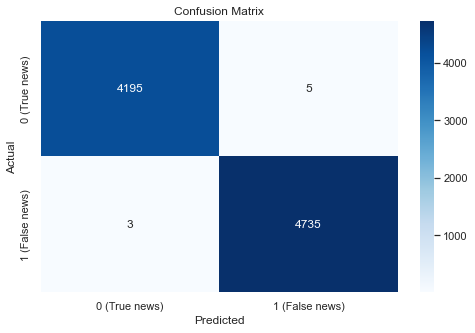

In [250]:
rnn_confusion_matrix = confusion_matrix(y_test, predicted_y_test)

plt.figure(figsize=(8, 5))

sns.set_theme(style="whitegrid", palette="bright")

heatmap = sns.heatmap(
    rnn_confusion_matrix,
    cmap="Blues",
    annot=True,
    fmt="d",
    xticklabels=["0 (True news)", "1 (False news)"],
    yticklabels=["0 (True news)", "1 (False news)"]
)
heatmap.set(
    xlabel="Predicted",
    ylabel="Actual",
    title="Confusion Matrix"
)

4-layered Model

In [ ]:
rnn_model2 = keras.Sequential()
rnn_model2.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=dim_size,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
)
rnn_model2.add(
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
)
rnn_model2.add(LSTM(units=16))
rnn_model2.add(Dense(1, activation="sigmoid"))
rnn_model2.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [239]:
rnn_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          21463400  
                                                                 
 lstm (LSTM)                 (None, 500, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 16)                9280      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 21,589,945
Trainable params: 126,545
Non-trainable params: 21,463,400
_________________________________________________________________


In [34]:
rnn_model2_history = rnn_model2.fit(
    x_train_seq, y_train, epochs=10, validation_data=(x_test_seq, y_test)
)
# 97.42, 99.29

Epoch 1/10
1118/1118 [==============================] - 1943s 2s/step - loss: 0.0936 - accuracy: 0.9679 - val_loss: 0.0261 - val_accuracy: 0.9924
Epoch 2/10
1118/1118 [==============================] - 1971s 2s/step - loss: 0.0234 - accuracy: 0.9933 - val_loss: 0.0123 - val_accuracy: 0.9965
Epoch 3/10
1118/1118 [==============================] - 2028s 2s/step - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.0084 - val_accuracy: 0.9974
Epoch 4/10
1118/1118 [==============================] - 2102s 2s/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.0094 - val_accuracy: 0.9980
Epoch 5/10
1118/1118 [==============================] - 2163s 2s/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch 6/10
1118/1118 [==============================] - 2251s 2s/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0058 - val_accuracy: 0.9983
Epoch 7/10
1118/1118 [==============================] - 2350s 2s/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0058 -

In [240]:
predicted_y_test = (rnn_model2.predict(x_test_seq) >= 0.5).astype(int)
rnn_acc = accuracy_score(y_test, predicted_y_test)

f"RNN Accuracy: {rnn_acc:.2%}"

280/280 [==============================] - 60s 209ms/step


'RNN Accuracy: 99.91%'

In [ ]:
# filename = 'model/rnn_model2.sav'
# pickle.dump(rnn_model2, open(filename, 'wb'))

In [39]:
# with open('model/rnn_model2_history', 'wb') as file_pi:
#     pickle.dump(rnn_model2_history.history, file_pi)

In [ ]:
train_accuracy = rnn_model2_history.history['accuracy']
train_loss = rnn_model2_history.history['loss']

train_accuracy

In [ ]:
# # Save model to disk
# filename = 'model/lr_model.sav'
# pickle.dump(lr_model, open(filename, 'wb'))

In [ ]:
# # Load model from disk
# filename = 'model/rnn_model2.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model.score(vectorised_x_test, y_test)

In [ ]:
# history = pickle.load(open('model/rnn_model2_history', "rb"))
# history

## Model Application

In [289]:
# _lr_model = pickle.load(open('model/lr_model.sav', 'rb'))
# _dt_model = pickle.load(open('model/dt_model.sav', 'rb'))
# _gbc_model = pickle.load(open('model/gbc_model.sav', 'rb'))
# _rfc_model = pickle.load(open('model/rfc_model.sav', 'rb'))
# _rnn_model = pickle.load(
#     open("C:/Users/Choong Man Shun/PycharmProjects/fake-news-detection/model/rnn_model.sav", "rb"))

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://eb4072d0-03b9-42f5-a894-0e1d06de6fc7/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [283]:
models = [
    ("Logistic Regression", _lr_model),
    ("Decision Tree Classifier", _dt_model),
    ("Gradient Boosting Classifier", _gbc_model),
    ("Random Forest Classifier", _rfc_model),
    ("Recurrent Neural Network", _rnn_model)
]
news_mapping = {0: "True news", 1: "Fake news"}

def predict(text):
    # Transform text
    text = clean_text(text)

    vectorised_text = vectorisation.transform([text])

    text_seq = tokenizer.texts_to_sequences([text])
    text_seq = pad_sequences(text_seq, maxlen=max_len)

    # Predict
    preds = []

    for model_name, model in models:
        neural_network = model_name == "Recurrent Neural Network"
        pred = model.predict(
            text_seq if neural_network else vectorised_text
        )[0]
        preds += [(model_name, pred[0] if neural_network else pred)]

    return preds

FileNotFoundError: [Errno 2] No such file or directory: '/model/lr_model.sav'

In [273]:
true_text = """
    Indonesia to buy $1.14 billion worth of Russian jets, JAKARTA (Reuters) - Indonesia will buy 11 Sukhoi fighter jets worth $1.14 billion from Russia in exchange for cash and Indonesian commodities, two cabinet ministers said on Tuesday. The Southeast Asian country has pledged to ship up to $570 million worth of commodities in addition to cash to pay for the Suhkoi SU-35 fighter jets, which are expected to be delivered in stages starting in two years. Indonesian Trade Minister Enggartiasto Lukita said in a joint statement with Defence Minister Ryamizard Ryacudu that details of the type and volume of commodities were  still being negotiated . Previously he had said the exports could include palm oil, tea, and coffee. The deal is expected to be finalised soon between Indonesian state trading company PT Perusahaan Perdangangan Indonesia and Russian state conglomerate Rostec. Russia is currently facing a new round of U.S.-imposed trade sanctions. Meanwhile, Southeast Asia s largest economy is trying to promote its palm oil products amid threats of a cut in consumption by European Union countries. Indonesia is also trying to modernize its ageing air force after a string of military aviation accidents. Indonesia, which had a $411 million trade surplus with Russia in 2016, wants to expand bilateral cooperation in tourism, education, energy, technology and aviation among others.
"""

text = input("Enter news text: ")
preds = predict(text)
for model, pred in preds:
    print(f"{model}:".ljust(29), f"{pred:.2%} ({news_mapping[pred >= 0.5]})")

1/1 [==============================] - 1s 646ms/step
Logistic Regression:          0.00% (True news)
Decision Tree Classifier:     0.00% (True news)
Gradient Boosting Classifier: 0.00% (True news)
Random Forest Classifier:     0.00% (True news)
Recurrent Neural Network:     0.00% (True news)


In [276]:
fake_text = """
    10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt, 21st Century Wire says As 21WIRE predicted in its new year s look ahead, we have a new  hostage  crisis underway.Today, Iranian military forces report that two small riverine U.S. Navy boats were seized in Iranian waters, and are currently being held on Iran s Farsi Island in the Persian Gulf. A total of 10 U.S. Navy personnel, nine men and one woman, have been detained by Iranian authorities. NAVY STRAYED: U.S. Navy patrol boat in the Persian Gulf (Image Source: USNI)According to the Pentagon, the initial narrative is as follows: The sailors were on a training mission around noon ET when their boat experienced mechanical difficulty and drifted into Iranian-claimed waters and were detained by the Iranian Coast Guard, officials added. The story has since been slightly revised by White House spokesman Josh Earnest to follow this narrative:The 2 boats were traveling en route from Kuwait to Bahrain, when they were stopped and detained by the Iranians.According to USNI, search and rescue teams from the Harry S. Truman Strike group were scrambled to aid the crew but stopped short after the crew was taken by the Iranians. We have been in contact with Iran and have received assurances that the crew and the vessels will be returned promptly,  Pentagon spokesman Peter Cook told AP. According to Persian Gulf TV: Farsi Island is one of the Iranian islands in the Persian Gulf, Bushehr province of Iran. There is an IRGC Navy base on this Island. The island has an area of about 0.25 km  and is completely restricted to public, due to top secret governmental activities. According to NBC News, U.S. State Department is in touch with Tehran officials and the Iranians recognize that the U.S. Navy straying off course was a mistake, and that the sailors will be released  within hours.  WAR INC: CNN s Wolf Blitzer wasted no time in ramping-up talk of military tension with Israeli-financed neocon Senator Tom Cotton.Neocon StuntAlready, the U.S. media, including CNN and FOX, are running with the talking point that,  this could not have come at a worse time for President Obama right before tonight s State Of Union speech, when he s trying to prove to the American people that Iran is a country that can be trusted to implement the historic nuclear deal. This latest Naval  controversy  also comes days before the implementation phase of the Iran Nuclear Deal. To say this is a coincidence might be naive.That said, could GOP and Israel-aligned members of the Pentagon or intelligence establishment have helped to engineer today s bizarre  mini-crisis  in order to help weaken U.S.-Iran relations, and by extension, Obama s controversial Iranian Nuclear Deal?This looks likely to be the case, as evidenced by the quick appearance of the Israel Lobby-sponsored, pro-war U.S. Senator Tom Cotton (R), placed by CNN to direct aggressive U.S. military talking points live on air as the story broke today. Cotton (photo, left) immediately called the event  hostile  and blamed Iran for the U.S. boat drifting into Iranian waters, and then blamed the  crisis  on President Obama, who he claims,  has emboldened the Iranian aggression. Cotton then goes on to tell a giant lie, on which his media handler, CNN s Wolf Blitzer, does not even blink, much less challenge Cotton s imaginary statement: The Iranians, who are largely responsible for killing our (American) soldiers in Iraq and Afghanistan. Cotton then went on to threaten Iran, saying that: These sailors and both vessels  need to be immediately released. If they are not released, then the Iran (nuclear) deal should not go forward, and military force will be on the table to retaliate for this act of aggression.  Cotton then proceeded to give a veiled (nuclear?) threat to Iran, saying that,  All (military) options should be on the table.  Would Washington s top operatives go so far as to engineer or exacerbate an international crisis such as this   by dispatching the boats off course, knowing full-well that Iran would not harm U.S. personnel, but using the incident to injure a lame duck? The answer is  yes , and they ve done it before In 1979, 52 American diplomats and citizens were held hostage for 444 days in what became known as the Iranian Hostage Crisis, which just happened to take place during a US presidential election cycle, with then president Jimmy Carter (D) running for reelection against challenger Ronald Reagan (R). The crisis, including a horrific failed rescue attempt, was used against Carter in the media. According to reports at the time Reagan campaign operatives had managed to do a backdoor deal with the elements of the new Iranian regime to  hold-off  releasing the hostages until after the election. In the end, Reagan won and took credit for that  victory .Not surprisingly, at the end of his prearranged CNN segment, Cotton invoked the  feckless foreign policy  of Jimmy Carter which  caused  the 1979 Iran Hostage Crisis, and compared that to President Obama s current policy.Of all the U.S. Officials CNN could have brought in on  short notice , they chose Senator Tom Cotton, the most hawkish and closest aligned to Israel. Clearly, this looks like a neocon stunt.Stay tuned for more updates.READ MORE IRAN NEWS AT: 21st Century Wire Iran Files
"""

text = input("Enter news text: ")
preds = predict(text)
for model, pred in preds:
    print(f"{model}:".ljust(29), f"{pred:.2%} ({news_mapping[pred >= 0.5]})")

1/1 [==============================] - 0s 250ms/step
Logistic Regression:          100.00% (Fake news)
Decision Tree Classifier:     100.00% (Fake news)
Gradient Boosting Classifier: 100.00% (Fake news)
Random Forest Classifier:     100.00% (Fake news)
Recurrent Neural Network:     100.00% (Fake news)


In [ ]:
# for text in news_text_df.text:
#     text, old_text = clean_text(text)
#
#     if text != old_text:
#         diff_index = 0
#         for i, (x, y) in enumerate(zip(text, old_text)):
#             if x != y and not diff_index:
#                 print(i, x, y)
#                 diff_index = i
#         print(old_text[diff_index-10:diff_index], old_text[diff_index:diff_index+90], sep='\t')
#         print(text[diff_index-10:diff_index], text[diff_index:diff_index+90], sep='\t')
#         print()

In [ ]:
# for text in news_text_df.text:
#     text, old_text = clean_text(text)
#
#     if text != old_text:
#         diff_index = 0
#         for i, (x, y) in enumerate(zip(text, old_text)):
#             if x != y and not diff_index:
#                 print(i, x, y)
#                 diff_index = i
#         print(old_text[diff_index-10:diff_index], old_text[diff_index:diff_index+90], sep='\t')
#         print(text[diff_index-10:diff_index], text[diff_index:diff_index+90], sep='\t')
#         print()
